In [1]:
import math
import numpy as np
from fractions import Fraction
from math import gcd
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# ---------------------------
# Helper: build permutation unitary for multiplication by 'a' modulo N
# ---------------------------
def modular_multiplication_unitary(a, N, n_target):
    """Return a 2^n_target x 2^n_target permutation matrix (numpy array)
       that maps |x> -> |(a*x) % N> for x < N, and leaves x>=N unchanged.
       This is a classical reversible mapping represented as a unitary."""
    dim = 2 ** n_target
    M = np.zeros((dim, dim), dtype=complex)

    for x in range(dim):
        if x < N:
            y = (a * x) % N
            M[y, x] = 1.0
        else:
            # keep the states outside [0, N-1] fixed (identity on those basis states)
            M[x, x] = 1.0
    return M


In [3]:

# ---------------------------
# Continued fraction routine to extract denominator (order candidate)
# ---------------------------
def continued_fraction_denominator(phase, max_denominator):
    """
    Given a phase in [0,1), find a small denominator r <= max_denominator
    such that r approximates the phase's rational representation.
    """
    # Use Fraction with a limit on denominator:
    frac = Fraction(phase).limit_denominator(max_denominator)
    return frac.denominator, frac.numerator


In [4]:

# ---------------------------
# QPE-based order finding
# ---------------------------
def find_order_qpe(a, N, n_count=8, shots=1024, plot_qc=True):
    """
    Uses QPE to estimate the phase corresponding to eigenvalue of
    modular multiplication by 'a' (acting on |1>), then applies continued
    fraction to extract candidate order r.
    Returns r (or None) and the circuit used.
    """
    if gcd(a, N) != 1:
        return None, None

    # number of target qubits needed to represent 0..N-1
    n_target = math.ceil(math.log2(N))
    if n_target == 0:
        n_target = 1

    # Build circuit with counting (phase) register and target register
    qc = QuantumCircuit(n_count + n_target, n_count)

    # Prepare counting qubits in |+>
    qc.h(range(n_count))
    # Prepare target register in |1> (|1> is commonly used as initial state for order-finding)
    qc.x(n_count + 0)  # set the least-significant target qubit to 1 -> state |1>

    # For each counting qubit apply controlled-U^{2^j}
    for j in range(n_count):
        exp = 2 ** j
        a_pow = pow(a, exp, N)
        # Build unitary for multiplication by a_pow (mod N)
        M = modular_multiplication_unitary(a_pow, N, n_target)
        u_gate = UnitaryGate(M, label=f"mul_{a_pow}_mod_{N}")

        # Controlled version of this gate (1 control)
        cu = u_gate.control(1)
        # The control qubit is j (counting qubit), target qubits are the n_target qubits
        control_qubit = j
        target_qubits = list(range(n_count, n_count + n_target))
        qc.append(cu, [control_qubit] + target_qubits)

    # Inverse QFT on counting (phase) qubits
    inv_qft = QFT(n_count, do_swaps=False).inverse()
    qc.append(inv_qft.to_gate(label="QFT^-1"), range(n_count))

    # Measurement of counting qubits
    qc.measure(range(n_count), range(n_count))

    # Show the circuit (mpl) if desired
    if plot_qc:
        print("Order-finding circuit (QPE part, inverse QFT, measurements):")
        display(qc.draw('mpl', scale=0.8))
        plt.show()

    # Run on AerSimulator
    backend = AerSimulator()
    # Transpile and run
    tqc = transpile(qc, backend=backend)
    job = backend.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    # show histogram for debugging/insight
    print("Measurement counts (top results):")
    display(plot_histogram(counts))
    plt.show()

    # pick the most likely bitstring
    most_common = max(counts, key=counts.get)
    measured_int = int(most_common, 2)
    phase = measured_int / (2 ** n_count)
    # convert to fraction to get denominator candidate
    denom, numer = continued_fraction_denominator(phase, N)
    return denom, qc


In [5]:

# ---------------------------
# Top-level Shor function (uses find_order_qpe)
# ---------------------------
def shors_algorithm(N, n_count=8, shots=1024, tries=5, show_circuit=True):
    """
    Attempt to factor N using a small-scale Shor demonstration.
    Tries up to `tries` different random a's (coprime to N).
    Returns a tuple of factors or None on failure.
    """
    if N % 2 == 0:
        return 2, N // 2

    for attempt in range(tries):
        a = np.random.randint(2, N)
        if gcd(a, N) != 1:
            # found a nontrivial factor immediately
            g = gcd(a, N)
            print(f"Found gcd({a},{N}) = {g} (trivial factor)")
            return g, N // g

        print(f"\nAttempt {attempt+1}: trying a = {a}")
        r, qc = find_order_qpe(a, N, n_count=n_count, shots=shots, plot_qc=show_circuit)
        if r is None:
            print("Failed to extract order from QPE result.")
            continue

        print(f"Candidate order r = {r}")

        # r must be even and a^{r/2} != -1 (mod N)
        if r % 2 != 0:
            print("r is odd; try another 'a'.")
            continue

        ar2 = pow(a, r // 2, N)
        if ar2 == N - 1:
            print("a^(r/2) ≡ -1 (mod N), try another 'a'.")
            continue

        # compute factors
        factor1 = gcd(ar2 - 1, N)
        factor2 = gcd(ar2 + 1, N)
        if factor1 in (1, N) or factor2 in (1, N):
            print("Found trivial factors; try again.")
            continue

        # success
        return factor1, factor2

    # if no factor found after tries
    return None


Running Shor's algorithm demo to factor N = 35

Attempt 1: trying a = 26


/tmp/ipykernel_4623/630506084.py:43: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  inv_qft = QFT(n_count, do_swaps=False).inverse()


Order-finding circuit (QPE part, inverse QFT, measurements):


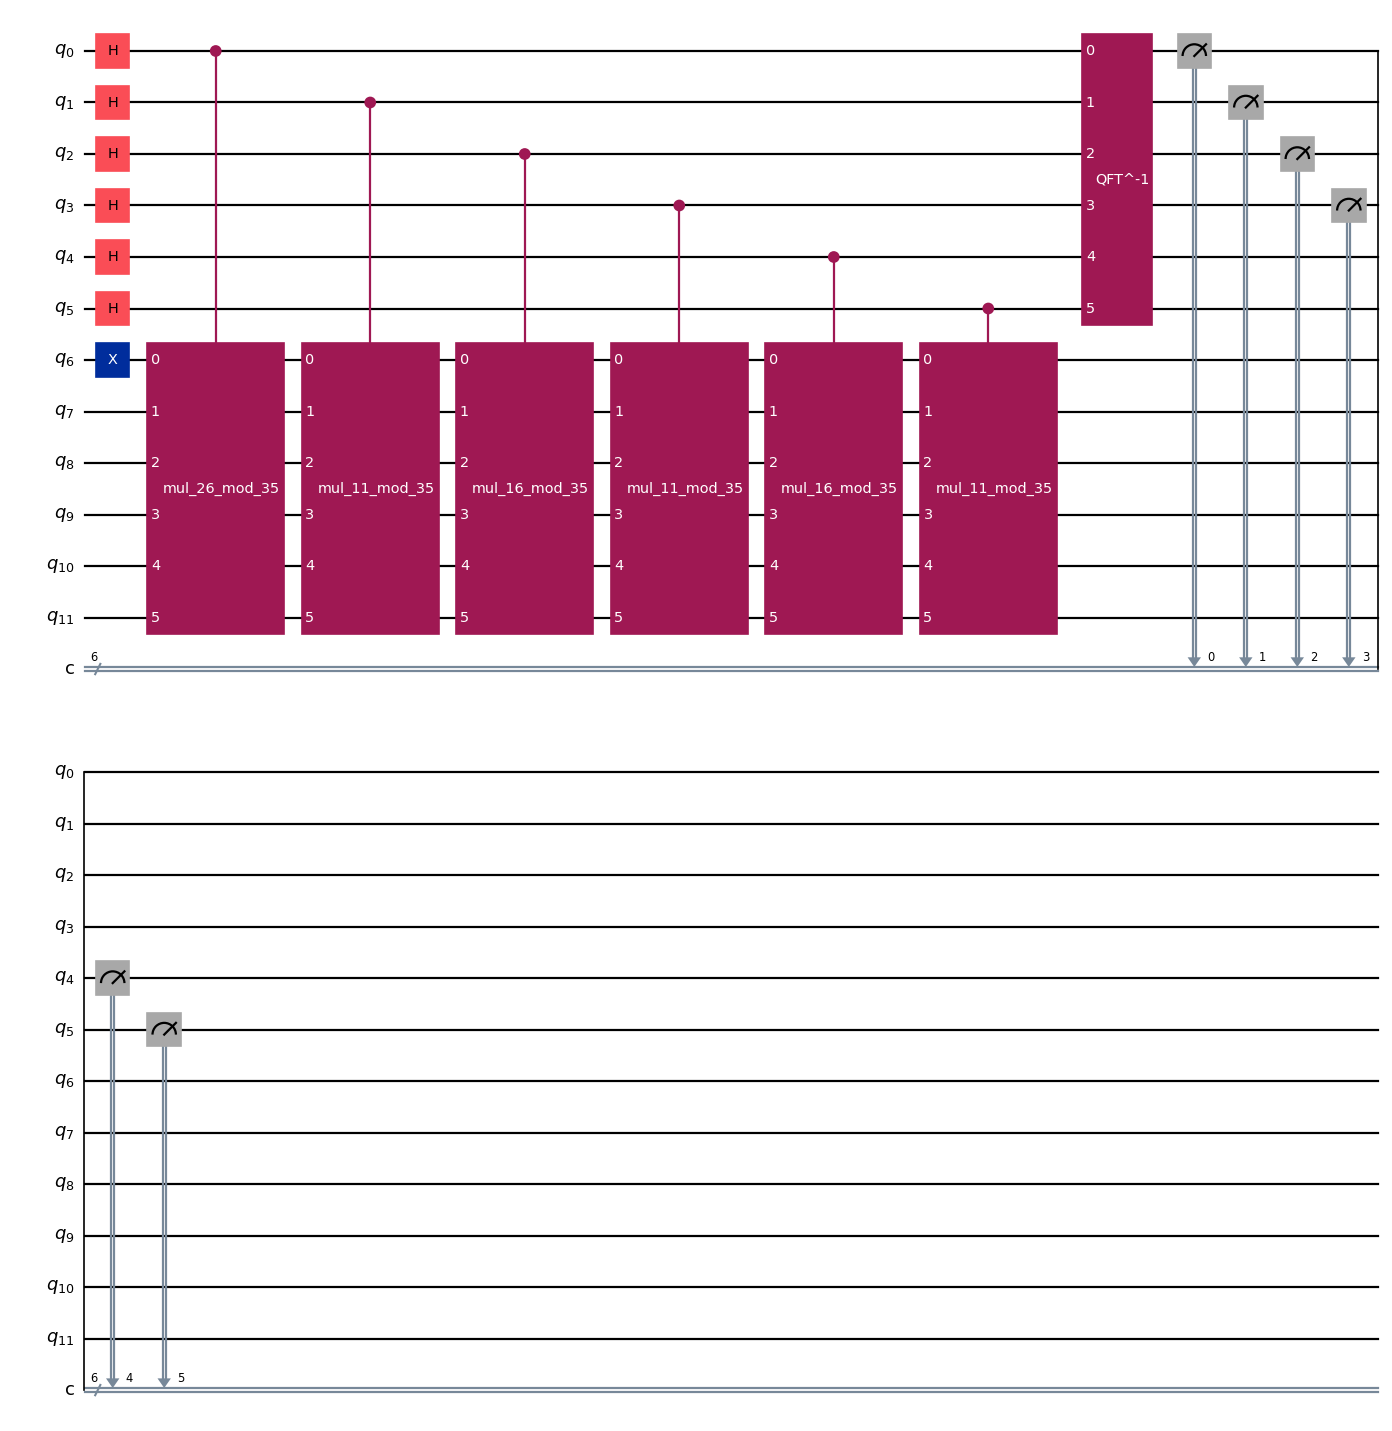

Measurement counts (top results):


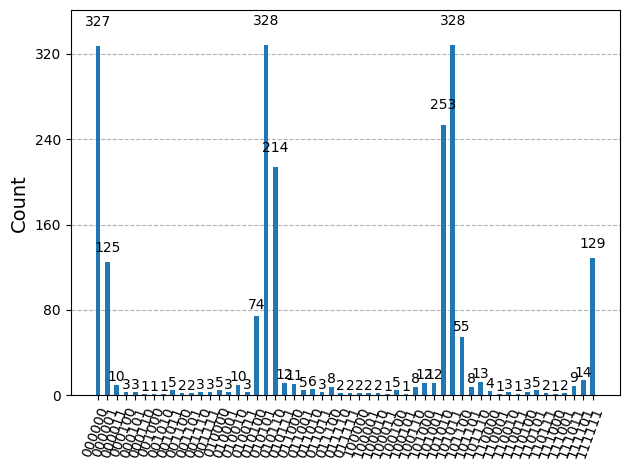

Candidate order r = 34
Found trivial factors; try again.

Attempt 2: trying a = 8


/tmp/ipykernel_4623/630506084.py:43: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  inv_qft = QFT(n_count, do_swaps=False).inverse()


Order-finding circuit (QPE part, inverse QFT, measurements):


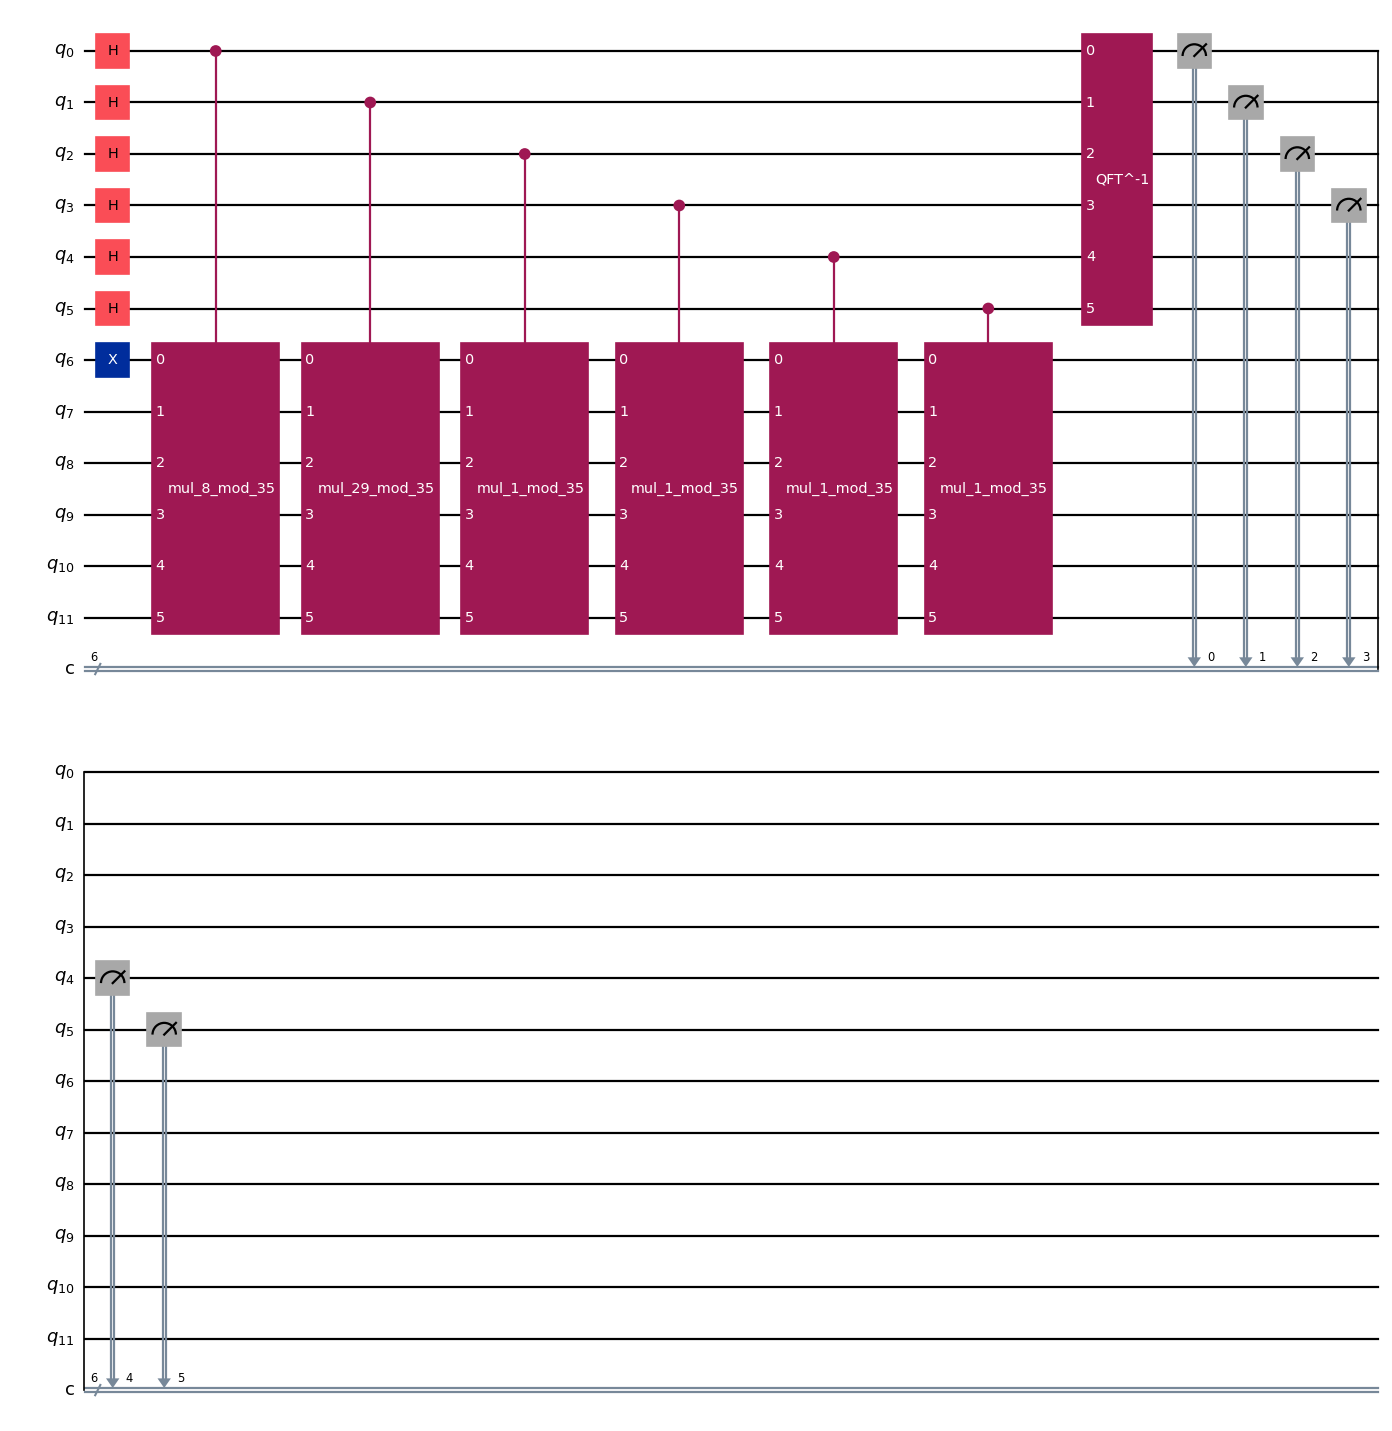

Measurement counts (top results):


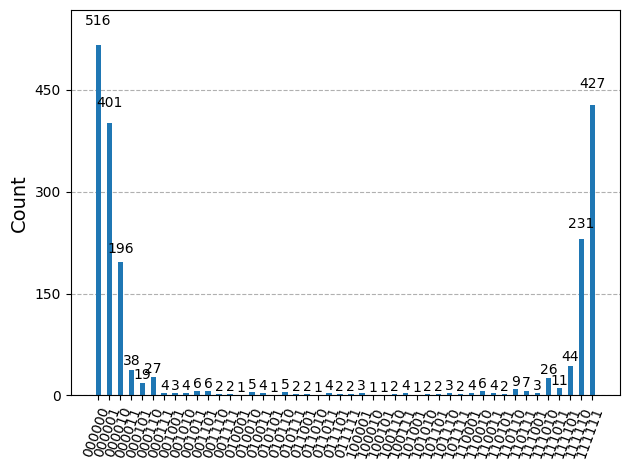

Candidate order r = 1
r is odd; try another 'a'.
Found gcd(10,35) = 5 (trivial factor)

Success! Found factors of 35: 5 and 7


In [7]:

# ---------------------------
# Example run: factor N=15 (classic demonstration)
# ---------------------------
N = 35  # change to other small N (composite) if you want to experiment
print(f"Running Shor's algorithm demo to factor N = {N}")
factors = shors_algorithm(N, n_count=6, shots=2048, tries=6, show_circuit=True)

if factors is None:
    print(f"\nFailed to find nontrivial factors of {N} after several attempts.")
else:
    print(f"\nSuccess! Found factors of {N}: {factors[0]} and {factors[1]}")
